In [ ]:
import os
import random
import yaml
import numpy as np
import pandas as pd
import torch
import torch.backends.cudnn
from ultralytics import YOLO
import matplotlib.pyplot as plt


SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


def get_image_files(folder):
    """Возвращает список файлов изображений (jpg/png и т.п.) из указанной папки."""
    return [f for f in os.listdir(folder) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

train_images_folder = "train/images"
valid_images_folder = "valid/images"

train_images = get_image_files(train_images_folder)
valid_images = get_image_files(valid_images_folder)

# Объединим их в один список с полными путями:
all_images = []
for img in train_images:
    all_images.append(os.path.join(train_images_folder, img))
for img in valid_images:
    all_images.append(os.path.join(valid_images_folder, img))

print("Всего изображений (train + valid):", len(all_images))

random.shuffle(all_images)

# Разбиваем на k фолдов
k_folds = 5
fold_size = len(all_images) // k_folds
folds = []
for i in range(k_folds):
    start = i * fold_size
    end = start + fold_size
    if i == k_folds - 1:  # последний фолд берёт всё, что осталось
        end = len(all_images)
    folds.append(all_images[start:end])


def create_data_files_for_fold(fold_idx, folds, base_data_yaml="data.yaml"):
    """
    - Создаёт fold_{i}/train.txt и fold_{i}/val.txt с путями к изображениям
    - Создаёт fold_{i}/data_fold_{i}.yaml, где train=ABS_PATH(train.txt), val=ABS_PATH(val.txt)
    Возвращает (абсолютный) путь к созданному data_fold_{i}.yaml
    """
    fold_dir = f"fold_{fold_idx}"
    os.makedirs(fold_dir, exist_ok=True)

    # Текущий фолд - валидация
    val_images = folds[fold_idx]
    # Остальные фолды - тренировка
    train_images = []
    for j in range(k_folds):
        if j != fold_idx:
            train_images.extend(folds[j])

    train_txt_rel = os.path.join(fold_dir, "train.txt")
    val_txt_rel   = os.path.join(fold_dir, "val.txt")

    with open(train_txt_rel, "w") as f:
        for path in train_images:
            f.write(path + "\n")

    with open(val_txt_rel, "w") as f:
        for path in val_images:
            f.write(path + "\n")

    train_txt_abs = os.path.abspath(train_txt_rel)
    val_txt_abs   = os.path.abspath(val_txt_rel)

    with open(base_data_yaml, "r") as f:
        data = yaml.safe_load(f)

    data["train"] = train_txt_abs
    data["val"]   = val_txt_abs

    fold_data_yaml_rel = os.path.join(fold_dir, f"data_fold_{fold_idx}.yaml")
    with open(fold_data_yaml_rel, "w") as f:
        yaml.dump(data, f, default_flow_style=False)

    return os.path.abspath(fold_data_yaml_rel)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

Всего изображений (train + valid): 4320
Device: cuda


In [ ]:
base_model = "yolo11s.pt"
num_epochs = 25

all_results = []

for fold_idx in range(k_folds):
    print(f"\n=== Обучение на фолде {fold_idx+1} из {k_folds} ===")
    
    fold_data_yaml_abs = create_data_files_for_fold(fold_idx, folds, base_data_yaml="data.yaml")
    
    model = YOLO(base_model)

    model.train(
        data=fold_data_yaml_abs,
        epochs=num_epochs,
        imgsz=416,
        optimizer='AdamW',
        lr0=1e-3,
        project='YOLO11s_fold',
        name=f'fold_{fold_idx}',
        batch=32,
        device=device,
        seed=SEED 
    )

    results_csv_path = os.path.join('YOLO11s_fold', f'fold_{fold_idx}', 'results.csv')
    if os.path.exists(results_csv_path):
        df_results = pd.read_csv(results_csv_path)
        df_results["fold"] = fold_idx
        all_results.append(df_results)
    else:
        print(f"Файл {results_csv_path} не найден. Проверьте, что обучение для fold_{fold_idx} завершилось корректно.")


=== Обучение на фолде 1 из 5 ===
New https://pypi.org/project/ultralytics/8.3.76 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.63 🚀 Python-3.10.12 torch-2.3.1 CUDA:0 (NVIDIA GeForce RTX 3090, 24252MiB)
engine/trainer: task=detect, mode=train, model=yolo11s.pt, data=/home/user/CourseWork/Disease/fold_0/data_fold_0.yaml, epochs=25, time=None, patience=100, batch=32, imgsz=416, save=True, save_period=-1, cache=False, device=cuda, workers=8, project=YOLO11s_fold, name=fold_0, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=True, seed=42, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Overriding model.yaml nc=80 with nc=12

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  3                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  4                  -1  1    103360  ultralytics.nn.modules.block.C3k2            [128, 256, 1, False, 0.25]    
  5                  -1  1    590336  ultralytics.nn.modules.conv.Conv             [256, 256, 3, 2]              
  6                  -1  1    346112  ultralytics.nn.modules.block.C3k2            [256, 256, 1, True]           
  7                  -1  1   1180672  ultralytic

train: Scanning train/labels... 3456 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3456/3456 [00:02<00:00, 1370.44it/s]


train: New cache created: train/labels.cache


val: Scanning train/labels... 864 images, 0 backgrounds, 0 corrupt: 100%|██████████| 864/864 [00:00<00:00, 1647.21it/s]

val: New cache created: train/labels.cache


Plotting labels to YOLO11s_fold/fold_0/labels.jpg... 
optimizer: AdamW(lr=0.001, momentum=0.937) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 416 train, 416 val
Using 8 dataloader workers
Logging results to YOLO11s_fold/fold_0
Starting training for 25 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/25       3.7G      1.149      1.945      1.423        134        416: 100%|██████████| 108/108 [00:15<00:00,  6.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.06it/s]

                   all        864       1930      0.485      0.536      0.506      0.315



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/25      3.84G      1.137      1.456      1.394        171        416: 100%|██████████| 108/108 [00:13<00:00,  8.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  4.87it/s]

                   all        864       1930      0.499      0.447      0.445      0.298



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/25       3.7G      1.071      1.279      1.335        142        416: 100%|██████████| 108/108 [00:12<00:00,  8.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.54it/s]


                   all        864       1930      0.483      0.503      0.454      0.298

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/25      3.69G      1.083      1.281      1.338        134        416: 100%|██████████| 108/108 [00:11<00:00,  9.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  4.84it/s]

                   all        864       1930      0.609      0.655      0.657      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/25      3.69G      1.046        1.2      1.309        134        416: 100%|██████████| 108/108 [00:14<00:00,  7.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  4.69it/s]

                   all        864       1930       0.74      0.624      0.657      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/25       3.7G     0.9987      1.102       1.28        130        416: 100%|██████████| 108/108 [00:14<00:00,  7.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  4.68it/s]

                   all        864       1930       0.74      0.711       0.78      0.543



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/25       3.7G     0.9809      1.049      1.261        126        416: 100%|██████████| 108/108 [00:14<00:00,  7.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  4.93it/s]

                   all        864       1930      0.726      0.733      0.762      0.555



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/25      3.71G     0.9634      1.002       1.25        136        416: 100%|██████████| 108/108 [00:14<00:00,  7.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  4.79it/s]

                   all        864       1930      0.813      0.781      0.823       0.61



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/25       3.7G     0.9336     0.9543      1.231        156        416: 100%|██████████| 108/108 [00:14<00:00,  7.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  4.84it/s]

                   all        864       1930      0.815      0.797      0.846      0.636



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/25      3.69G     0.9073      0.931      1.217        129        416: 100%|██████████| 108/108 [00:14<00:00,  7.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  4.81it/s]

                   all        864       1930      0.788      0.806      0.838      0.629



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/25      3.71G     0.8914      0.896      1.206        130        416: 100%|██████████| 108/108 [00:14<00:00,  7.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.60it/s]

                   all        864       1930      0.762      0.785      0.833       0.63



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/25      3.71G     0.8738     0.8504       1.19        132        416: 100%|██████████| 108/108 [00:14<00:00,  7.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  4.83it/s]

                   all        864       1930      0.842       0.78      0.857      0.662



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/25      3.66G     0.8814     0.8358      1.192        155        416: 100%|██████████| 108/108 [00:14<00:00,  7.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  4.83it/s]

                   all        864       1930      0.834       0.84      0.884      0.678



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/25       3.7G     0.8453     0.8128      1.176        138        416: 100%|██████████| 108/108 [00:14<00:00,  7.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  4.80it/s]

                   all        864       1930      0.843       0.83      0.877      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/25       3.7G     0.8307     0.7838      1.163        111        416: 100%|██████████| 108/108 [00:14<00:00,  7.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  4.92it/s]

                   all        864       1930      0.859      0.821      0.881      0.693


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/25      3.68G      0.748     0.6918      1.114         67        416: 100%|██████████| 108/108 [00:14<00:00,  7.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  4.82it/s]

                   all        864       1930      0.851      0.837      0.883      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/25      3.68G     0.7192     0.6408      1.096         45        416: 100%|██████████| 108/108 [00:13<00:00,  7.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  4.82it/s]

                   all        864       1930      0.823      0.839       0.87      0.684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/25      3.68G     0.7184      0.626      1.105         68        416: 100%|██████████| 108/108 [00:13<00:00,  8.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  4.72it/s]

                   all        864       1930      0.873      0.854      0.895      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/25      3.68G     0.6882     0.5901      1.082         65        416: 100%|██████████| 108/108 [00:13<00:00,  7.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  4.75it/s]

                   all        864       1930       0.88      0.828      0.892      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/25      3.68G     0.6768     0.5675      1.069         56        416: 100%|██████████| 108/108 [00:14<00:00,  7.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  4.82it/s]

                   all        864       1930      0.873      0.847      0.901       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/25      3.68G     0.6661     0.5522      1.062         77        416: 100%|██████████| 108/108 [00:13<00:00,  7.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  4.89it/s]

                   all        864       1930      0.896      0.862      0.918      0.753



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/25       3.7G     0.6384     0.5149      1.044         73        416: 100%|██████████| 108/108 [00:13<00:00,  7.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  4.86it/s]

                   all        864       1930      0.891      0.871      0.917      0.754



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/25       3.7G     0.6301     0.4884       1.04         60        416: 100%|██████████| 108/108 [00:13<00:00,  7.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  4.90it/s]

                   all        864       1930      0.897      0.885      0.926      0.765



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/25      3.68G     0.6139     0.4748      1.028         72        416: 100%|██████████| 108/108 [00:13<00:00,  7.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  4.89it/s]

                   all        864       1930      0.898      0.888      0.927      0.768



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/25      3.68G     0.6046     0.4605       1.02         50        416: 100%|██████████| 108/108 [00:13<00:00,  7.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  4.91it/s]

                   all        864       1930      0.889      0.901      0.929      0.777



25 epochs completed in 0.125 hours.
Optimizer stripped from YOLO11s_fold/fold_0/weights/last.pt, 19.2MB
Optimizer stripped from YOLO11s_fold/fold_0/weights/best.pt, 19.2MB

Validating YOLO11s_fold/fold_0/weights/best.pt...
Ultralytics 8.3.63 🚀 Python-3.10.12 torch-2.3.1 CUDA:0 (NVIDIA GeForce RTX 3090, 24252MiB)
YOLO11s summary (fused): 238 layers, 9,417,444 parameters, 0 gradients, 21.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  3.51it/s]


                   all        864       1930      0.889      0.901      0.929      0.776
Beans_Angular_LeafSpot         59        208      0.754       0.78      0.788      0.516
            Beans_Rust         92        448      0.806      0.827      0.889      0.679
Strawberry_Angular_LeafSpot         70         87      0.931       0.93      0.961      0.822
Strawberry_Anthracnose_Fruit_Rot         31         41      0.924      0.887       0.92      0.625
Strawberry_Blossom_Blight         53         83      0.905          1      0.973      0.843
  Strawberry_Gray_Mold         69         77      0.848      0.869      0.943      0.671
  Strawberry_Leaf_Spot         88        365      0.914      0.928      0.969      0.885
Strawberry_Powdery_Mildew_Fruit         38         89      0.934      0.876      0.943      0.775
Strawberry_Powdery_Mildew_Leaf         69        232      0.762      0.802      0.851      0.729
         Tomato_Blight         86         87      0.951      0.966      0.9

train: Scanning train/labels... 3456 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3456/3456 [00:02<00:00, 1611.89it/s]


train: New cache created: train/labels.cache


val: Scanning train/labels... 864 images, 0 backgrounds, 0 corrupt: 100%|██████████| 864/864 [00:00<00:00, 1638.67it/s]

val: New cache created: train/labels.cache


Plotting labels to YOLO11s_fold/fold_1/labels.jpg... 
optimizer: AdamW(lr=0.001, momentum=0.937) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 416 train, 416 val
Using 8 dataloader workers
Logging results to YOLO11s_fold/fold_1
Starting training for 25 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/25      3.76G      1.133      1.977      1.407        135        416: 100%|██████████| 108/108 [00:15<00:00,  7.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  4.77it/s]


                   all        864       1884       0.58      0.235      0.329       0.17

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/25      3.85G      1.127      1.456       1.37        176        416: 100%|██████████| 108/108 [00:13<00:00,  7.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  4.69it/s]


                   all        864       1884      0.645      0.564      0.624      0.397

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/25      3.71G      1.072      1.294      1.341        117        416: 100%|██████████| 108/108 [00:14<00:00,  7.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.53it/s]


                   all        864       1884       0.51      0.508      0.504      0.304

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/25       3.7G       1.08      1.277      1.328        134        416: 100%|██████████| 108/108 [00:13<00:00,  7.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.56it/s]

                   all        864       1884      0.656      0.671      0.706      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/25      3.69G       1.05       1.18      1.308        127        416: 100%|██████████| 108/108 [00:14<00:00,  7.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.49it/s]


                   all        864       1884        0.6      0.648      0.653      0.455

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/25      3.71G      1.004      1.093      1.279        123        416: 100%|██████████| 108/108 [00:14<00:00,  7.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  4.67it/s]

                   all        864       1884       0.73      0.739      0.766      0.557



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/25      3.69G     0.9697       1.04      1.256        113        416: 100%|██████████| 108/108 [00:13<00:00,  7.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  4.73it/s]

                   all        864       1884       0.78      0.765      0.812      0.605



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/25      3.71G     0.9534      1.005      1.246        132        416: 100%|██████████| 108/108 [00:14<00:00,  7.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  4.74it/s]

                   all        864       1884      0.784      0.812      0.822       0.62



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/25      3.69G     0.9293     0.9627      1.231        122        416: 100%|██████████| 108/108 [00:13<00:00,  7.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  4.73it/s]


                   all        864       1884      0.794      0.743      0.826      0.623

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/25      3.68G     0.9248     0.9372       1.22        148        416: 100%|██████████| 108/108 [00:13<00:00,  7.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  4.69it/s]

                   all        864       1884      0.796       0.79      0.837      0.643



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/25       3.7G     0.8837     0.8794      1.203        158        416: 100%|██████████| 108/108 [00:13<00:00,  7.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  4.68it/s]

                   all        864       1884      0.828      0.802      0.854      0.655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/25      3.71G     0.8771     0.8498      1.194        126        416: 100%|██████████| 108/108 [00:13<00:00,  7.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  4.75it/s]

                   all        864       1884       0.85      0.813      0.872      0.684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/25       3.7G     0.8595     0.8201       1.18        117        416: 100%|██████████| 108/108 [00:13<00:00,  7.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  4.77it/s]

                   all        864       1884      0.851      0.846      0.887      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/25       3.7G     0.8419     0.8021      1.175        129        416: 100%|██████████| 108/108 [00:14<00:00,  7.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  4.70it/s]

                   all        864       1884      0.864      0.835      0.895      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/25      3.69G     0.8339     0.7811      1.166        122        416: 100%|██████████| 108/108 [00:14<00:00,  7.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  4.71it/s]

                   all        864       1884      0.844      0.857      0.891      0.712


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/25      3.68G     0.7502     0.7183       1.12         60        416: 100%|██████████| 108/108 [00:13<00:00,  7.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  4.77it/s]

                   all        864       1884      0.833      0.855      0.899      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/25      3.68G     0.7325     0.6511      1.107         49        416: 100%|██████████| 108/108 [00:13<00:00,  7.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.66it/s]

                   all        864       1884      0.865      0.851      0.896      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/25      3.68G     0.7075     0.6177      1.096         75        416: 100%|██████████| 108/108 [00:13<00:00,  7.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.58it/s]

                   all        864       1884      0.848      0.873       0.91      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/25      3.68G     0.6807     0.5919      1.074         64        416: 100%|██████████| 108/108 [00:13<00:00,  7.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  4.69it/s]

                   all        864       1884      0.887      0.853      0.907      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/25      3.68G      0.681     0.5651      1.068         62        416: 100%|██████████| 108/108 [00:13<00:00,  7.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.62it/s]

                   all        864       1884      0.891      0.864      0.916      0.746



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/25      3.68G     0.6662     0.5467      1.058         69        416: 100%|██████████| 108/108 [00:13<00:00,  7.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  4.68it/s]

                   all        864       1884        0.9      0.883      0.931      0.767



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/25       3.7G     0.6469     0.5133      1.048         67        416: 100%|██████████| 108/108 [00:14<00:00,  7.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  4.70it/s]

                   all        864       1884      0.899      0.889      0.934      0.781



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/25      3.68G     0.6249     0.4941      1.035         60        416: 100%|██████████| 108/108 [00:14<00:00,  7.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  4.68it/s]

                   all        864       1884      0.907       0.88      0.934      0.777



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/25      3.68G     0.6174     0.4791      1.031         67        416: 100%|██████████| 108/108 [00:14<00:00,  7.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  4.76it/s]

                   all        864       1884      0.909      0.891      0.938      0.787



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/25      3.68G     0.6038     0.4592      1.021         64        416: 100%|██████████| 108/108 [00:14<00:00,  7.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.66it/s]

                   all        864       1884      0.917       0.89      0.941      0.793



25 epochs completed in 0.126 hours.
Optimizer stripped from YOLO11s_fold/fold_1/weights/last.pt, 19.2MB
Optimizer stripped from YOLO11s_fold/fold_1/weights/best.pt, 19.2MB

Validating YOLO11s_fold/fold_1/weights/best.pt...
Ultralytics 8.3.63 🚀 Python-3.10.12 torch-2.3.1 CUDA:0 (NVIDIA GeForce RTX 3090, 24252MiB)
YOLO11s summary (fused): 238 layers, 9,417,444 parameters, 0 gradients, 21.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  3.46it/s]


                   all        864       1884      0.916      0.891      0.941      0.793
Beans_Angular_LeafSpot         88        280      0.857      0.761       0.85       0.57
            Beans_Rust         81        410      0.871      0.817      0.904      0.693
Strawberry_Angular_LeafSpot         69         89      0.964       0.91      0.959      0.803
Strawberry_Anthracnose_Fruit_Rot         26         45      0.847      0.689      0.846       0.63
Strawberry_Blossom_Blight         51         74      0.948      0.995      0.994      0.854
  Strawberry_Gray_Mold         83         86      0.957      0.965      0.969      0.729
  Strawberry_Leaf_Spot         90        330      0.951      0.879      0.971      0.896
Strawberry_Powdery_Mildew_Fruit         46        101      0.872      0.879       0.94      0.786
Strawberry_Powdery_Mildew_Leaf         68        206      0.769      0.826      0.896      0.754
         Tomato_Blight         86         87      0.988      0.989      0.9

train: Scanning train/labels... 3456 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3456/3456 [00:02<00:00, 1465.90it/s]


train: New cache created: train/labels.cache


val: Scanning train/labels... 864 images, 0 backgrounds, 0 corrupt: 100%|██████████| 864/864 [00:00<00:00, 1540.83it/s]

val: New cache created: train/labels.cache


Plotting labels to YOLO11s_fold/fold_2/labels.jpg... 
optimizer: AdamW(lr=0.001, momentum=0.937) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 416 train, 416 val
Using 8 dataloader workers
Logging results to YOLO11s_fold/fold_2
Starting training for 25 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/25      3.77G       1.15      2.032        1.4        125        416: 100%|██████████| 108/108 [00:15<00:00,  7.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.48it/s]


                   all        864       1795      0.498       0.43       0.41      0.253

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/25      3.84G      1.126      1.431      1.361        168        416: 100%|██████████| 108/108 [00:13<00:00,  7.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.24it/s]


                   all        864       1795      0.553      0.478      0.508      0.346

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/25       3.7G       1.07      1.291      1.328        145        416: 100%|██████████| 108/108 [00:14<00:00,  7.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  4.67it/s]


                   all        864       1795      0.636      0.648      0.649      0.434

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/25       3.7G      1.072      1.256      1.331        128        416: 100%|██████████| 108/108 [00:13<00:00,  7.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.56it/s]

                   all        864       1795      0.612      0.658      0.664      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/25      3.71G      1.051      1.201      1.304        127        416: 100%|██████████| 108/108 [00:14<00:00,  7.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  4.68it/s]

                   all        864       1795      0.616      0.608      0.655      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/25      3.72G      1.004      1.097      1.275        140        416: 100%|██████████| 108/108 [00:14<00:00,  7.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  4.81it/s]

                   all        864       1795      0.744      0.728      0.791      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/25      3.68G     0.9729      1.022      1.253        113        416: 100%|██████████| 108/108 [00:14<00:00,  7.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.64it/s]

                   all        864       1795      0.728      0.727      0.739      0.557



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/25      3.69G     0.9619      1.045      1.249        127        416: 100%|██████████| 108/108 [00:14<00:00,  7.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  4.68it/s]

                   all        864       1795      0.775      0.708      0.786      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/25      3.68G     0.9354     0.9649      1.224        143        416: 100%|██████████| 108/108 [00:14<00:00,  7.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  4.71it/s]

                   all        864       1795      0.802      0.784      0.847      0.648



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/25      3.71G      0.916     0.9163      1.211        131        416: 100%|██████████| 108/108 [00:14<00:00,  7.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  4.74it/s]

                   all        864       1795       0.81      0.805      0.858       0.66



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/25      3.71G     0.8905     0.8878      1.201        153        416: 100%|██████████| 108/108 [00:14<00:00,  7.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.55it/s]

                   all        864       1795      0.796      0.794      0.847      0.654



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/25       3.7G     0.8751      0.854      1.186        137        416: 100%|██████████| 108/108 [00:14<00:00,  7.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  4.69it/s]

                   all        864       1795      0.797      0.855      0.872      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/25       3.7G     0.8732     0.8387      1.187        147        416: 100%|██████████| 108/108 [00:14<00:00,  7.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.65it/s]

                   all        864       1795      0.801      0.802      0.866      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/25      3.71G     0.8511     0.7979      1.171        124        416: 100%|██████████| 108/108 [00:14<00:00,  7.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  4.70it/s]

                   all        864       1795       0.82      0.843      0.868      0.682



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/25      3.71G     0.8349     0.7686      1.161        118        416: 100%|██████████| 108/108 [00:11<00:00,  9.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  4.91it/s]

                   all        864       1795      0.842      0.852      0.875      0.692


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/25      3.72G     0.7492     0.6878      1.111         61        416: 100%|██████████| 108/108 [00:12<00:00,  8.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  4.69it/s]

                   all        864       1795      0.859      0.831      0.884      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/25      3.68G     0.7286     0.6366      1.092         53        416: 100%|██████████| 108/108 [00:13<00:00,  8.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.56it/s]

                   all        864       1795      0.846      0.866      0.901      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/25      3.69G     0.7115     0.6138      1.077         76        416: 100%|██████████| 108/108 [00:11<00:00,  9.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  4.92it/s]

                   all        864       1795      0.853      0.859      0.895      0.729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/25      3.68G     0.6903      0.584      1.066         58        416: 100%|██████████| 108/108 [00:11<00:00,  9.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  4.82it/s]

                   all        864       1795      0.871      0.893      0.924      0.759



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/25      3.69G     0.6689     0.5535      1.054         46        416: 100%|██████████| 108/108 [00:11<00:00,  9.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  4.96it/s]

                   all        864       1795       0.91      0.864      0.926      0.764



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/25      3.68G     0.6524     0.5366      1.047         88        416: 100%|██████████| 108/108 [00:13<00:00,  8.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  4.84it/s]

                   all        864       1795      0.904      0.885       0.93      0.769



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/25      3.69G     0.6412       0.51      1.037         70        416: 100%|██████████| 108/108 [00:11<00:00,  9.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  4.82it/s]

                   all        864       1795      0.911      0.863       0.93      0.777



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/25      3.68G     0.6266      0.499       1.03         55        416: 100%|██████████| 108/108 [00:13<00:00,  8.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  4.89it/s]

                   all        864       1795      0.906      0.897      0.936       0.79



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/25      3.69G     0.6164     0.4756      1.024         81        416: 100%|██████████| 108/108 [00:13<00:00,  7.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.49it/s]

                   all        864       1795      0.908      0.903      0.943      0.798



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/25       3.7G     0.6031     0.4519      1.013         61        416: 100%|██████████| 108/108 [00:13<00:00,  7.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.59it/s]

                   all        864       1795      0.906      0.913      0.943        0.8



25 epochs completed in 0.123 hours.
Optimizer stripped from YOLO11s_fold/fold_2/weights/last.pt, 19.2MB
Optimizer stripped from YOLO11s_fold/fold_2/weights/best.pt, 19.2MB

Validating YOLO11s_fold/fold_2/weights/best.pt...
Ultralytics 8.3.63 🚀 Python-3.10.12 torch-2.3.1 CUDA:0 (NVIDIA GeForce RTX 3090, 24252MiB)
YOLO11s summary (fused): 238 layers, 9,417,444 parameters, 0 gradients, 21.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  3.31it/s]


                   all        864       1795      0.906      0.913      0.943        0.8
Beans_Angular_LeafSpot         71        235      0.861      0.767      0.852      0.551
            Beans_Rust         83        383      0.794      0.854      0.919      0.714
Strawberry_Angular_LeafSpot         69         84      0.951      0.926      0.941      0.823
Strawberry_Anthracnose_Fruit_Rot         28         45      0.912       0.92      0.976      0.711
Strawberry_Blossom_Blight         72        102      0.983      0.971      0.994      0.903
  Strawberry_Gray_Mold         91         98      0.944      0.898      0.943      0.687
  Strawberry_Leaf_Spot         86        273      0.928       0.96      0.982      0.929
Strawberry_Powdery_Mildew_Fruit         35         75      0.807      0.787      0.847      0.677
Strawberry_Powdery_Mildew_Leaf         77        245      0.729      0.894      0.888      0.771
         Tomato_Blight         82         82          1      0.996      0.9

train: Scanning train/labels... 3456 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3456/3456 [00:02<00:00, 1646.17it/s]

train: New cache created: train/labels.cache



val: Scanning train/labels... 864 images, 0 backgrounds, 0 corrupt: 100%|██████████| 864/864 [00:00<00:00, 1604.77it/s]

val: New cache created: train/labels.cache


Plotting labels to YOLO11s_fold/fold_3/labels.jpg... 
optimizer: AdamW(lr=0.001, momentum=0.937) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 416 train, 416 val
Using 8 dataloader workers
Logging results to YOLO11s_fold/fold_3
Starting training for 25 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/25      3.77G      1.142      2.005       1.41        138        416: 100%|██████████| 108/108 [00:14<00:00,  7.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  4.79it/s]


                   all        864       1994      0.375      0.387      0.359      0.229

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/25      3.72G      1.116      1.428      1.378        158        416: 100%|██████████| 108/108 [00:14<00:00,  7.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.61it/s]


                   all        864       1994      0.558      0.645      0.619      0.409

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/25      3.72G      1.081      1.295      1.353        142        416: 100%|██████████| 108/108 [00:13<00:00,  7.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.47it/s]


                   all        864       1994      0.539       0.51      0.497      0.311

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/25       3.7G      1.081      1.265      1.344        120        416: 100%|██████████| 108/108 [00:13<00:00,  7.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  4.67it/s]

                   all        864       1994      0.571      0.632      0.632      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/25       3.7G      1.046       1.19      1.326        131        416: 100%|██████████| 108/108 [00:13<00:00,  7.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.59it/s]


                   all        864       1994      0.661      0.753      0.778      0.547

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/25      3.72G      1.008      1.107      1.304        127        416: 100%|██████████| 108/108 [00:14<00:00,  7.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  4.70it/s]

                   all        864       1994      0.712      0.703      0.762      0.553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/25      3.72G     0.9736      1.049      1.276        124        416: 100%|██████████| 108/108 [00:14<00:00,  7.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  4.69it/s]

                   all        864       1994      0.709      0.758      0.786      0.553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/25      3.72G     0.9538      1.003      1.259        128        416: 100%|██████████| 108/108 [00:14<00:00,  7.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  4.69it/s]

                   all        864       1994      0.717      0.692      0.755      0.557



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/25      3.71G     0.9359     0.9605       1.25        143        416: 100%|██████████| 108/108 [00:13<00:00,  7.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  4.77it/s]

                   all        864       1994       0.74      0.778      0.805      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/25      3.72G     0.9197     0.9345      1.239        156        416: 100%|██████████| 108/108 [00:14<00:00,  7.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  4.78it/s]

                   all        864       1994      0.743      0.783      0.813      0.614



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/25      3.73G     0.8971     0.8984      1.225        129        416: 100%|██████████| 108/108 [00:13<00:00,  7.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  4.67it/s]

                   all        864       1994      0.803      0.784      0.841      0.637



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/25      3.71G     0.8835     0.8545      1.214        134        416: 100%|██████████| 108/108 [00:14<00:00,  7.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.60it/s]

                   all        864       1994      0.839      0.827      0.878      0.676



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/25      3.73G     0.8736     0.8483       1.21        124        416: 100%|██████████| 108/108 [00:14<00:00,  7.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  4.87it/s]

                   all        864       1994        0.8      0.835      0.877      0.671



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/25       3.7G     0.8607     0.8175      1.199        144        416: 100%|██████████| 108/108 [00:14<00:00,  7.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  4.92it/s]

                   all        864       1994      0.824      0.838      0.885      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/25      3.73G     0.8347     0.7872      1.183        123        416: 100%|██████████| 108/108 [00:13<00:00,  7.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  4.71it/s]

                   all        864       1994       0.83      0.872      0.892      0.701


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/25      3.71G     0.7524     0.7121      1.151         65        416: 100%|██████████| 108/108 [00:13<00:00,  7.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.63it/s]

                   all        864       1994      0.849      0.839      0.894      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/25       3.7G     0.7379     0.6601      1.145         60        416: 100%|██████████| 108/108 [00:13<00:00,  7.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.66it/s]

                   all        864       1994      0.857      0.864      0.903      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/25      3.72G     0.7155     0.6268       1.13         58        416: 100%|██████████| 108/108 [00:14<00:00,  7.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.64it/s]

                   all        864       1994      0.856      0.865      0.901      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/25       3.7G     0.7019     0.5946      1.123         71        416: 100%|██████████| 108/108 [00:13<00:00,  8.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  4.75it/s]

                   all        864       1994      0.869      0.879      0.905      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/25      3.71G     0.6714     0.5725      1.099         61        416: 100%|██████████| 108/108 [00:13<00:00,  8.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  4.88it/s]

                   all        864       1994       0.88       0.89      0.913      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/25      3.69G     0.6629      0.551      1.091         72        416: 100%|██████████| 108/108 [00:12<00:00,  8.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  4.84it/s]

                   all        864       1994      0.895      0.887      0.916      0.753



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/25      3.72G     0.6424     0.5163      1.077         72        416: 100%|██████████| 108/108 [00:13<00:00,  8.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  4.75it/s]

                   all        864       1994      0.891      0.895      0.925      0.767



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/25       3.7G     0.6326      0.493      1.074         60        416: 100%|██████████| 108/108 [00:12<00:00,  8.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  4.96it/s]

                   all        864       1994       0.91       0.89      0.924       0.77



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/25       3.7G     0.6165     0.4835      1.059         55        416: 100%|██████████| 108/108 [00:11<00:00,  9.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  4.97it/s]

                   all        864       1994       0.91      0.889      0.928      0.773



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/25       3.7G     0.6048     0.4602      1.051         63        416: 100%|██████████| 108/108 [00:11<00:00,  9.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.01it/s]

                   all        864       1994        0.9      0.908       0.93      0.776



25 epochs completed in 0.124 hours.
Optimizer stripped from YOLO11s_fold/fold_3/weights/last.pt, 19.2MB
Optimizer stripped from YOLO11s_fold/fold_3/weights/best.pt, 19.2MB

Validating YOLO11s_fold/fold_3/weights/best.pt...
Ultralytics 8.3.63 🚀 Python-3.10.12 torch-2.3.1 CUDA:0 (NVIDIA GeForce RTX 3090, 24252MiB)
YOLO11s summary (fused): 238 layers, 9,417,444 parameters, 0 gradients, 21.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  3.45it/s]


                   all        864       1994        0.9      0.908       0.93      0.776
Beans_Angular_LeafSpot         78        272      0.781      0.746      0.766      0.497
            Beans_Rust         91        476      0.885      0.809      0.899      0.676
Strawberry_Angular_LeafSpot         66         75      0.944      0.973      0.984      0.851
Strawberry_Anthracnose_Fruit_Rot         34         59      0.863      0.797      0.821      0.545
Strawberry_Blossom_Blight         58         83      0.924          1      0.994      0.845
  Strawberry_Gray_Mold         67         68      0.885      0.941      0.951      0.715
  Strawberry_Leaf_Spot         91        335      0.919      0.931      0.979      0.904
Strawberry_Powdery_Mildew_Fruit         42         85      0.889      0.906      0.954      0.779
Strawberry_Powdery_Mildew_Leaf         78        280      0.729      0.797      0.832      0.704
         Tomato_Blight         93         93      0.993          1      0.9

train: Scanning train/labels... 3456 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3456/3456 [00:01<00:00, 1881.31it/s]


train: New cache created: train/labels.cache


val: Scanning train/labels... 864 images, 0 backgrounds, 0 corrupt: 100%|██████████| 864/864 [00:00<00:00, 1640.46it/s]

val: New cache created: train/labels.cache


Plotting labels to YOLO11s_fold/fold_4/labels.jpg... 
optimizer: AdamW(lr=0.001, momentum=0.937) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 416 train, 416 val
Using 8 dataloader workers
Logging results to YOLO11s_fold/fold_4
Starting training for 25 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/25      3.77G      1.147      2.002      1.408        124        416: 100%|██████████| 108/108 [00:14<00:00,  7.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.60it/s]


                   all        864       1886      0.632      0.293      0.336      0.156

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/25      3.73G      1.112      1.435      1.354        171        416: 100%|██████████| 108/108 [00:13<00:00,  7.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.60it/s]


                   all        864       1886      0.636      0.499      0.548      0.356

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/25      3.73G       1.07      1.295       1.32        134        416: 100%|██████████| 108/108 [00:14<00:00,  7.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.60it/s]

                   all        864       1886      0.562      0.496      0.514      0.329



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/25      3.72G      1.079      1.249      1.327        139        416: 100%|██████████| 108/108 [00:14<00:00,  7.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  4.79it/s]

                   all        864       1886       0.62      0.671      0.672      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/25      3.72G      1.046        1.2      1.294        131        416: 100%|██████████| 108/108 [00:13<00:00,  8.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.61it/s]

                   all        864       1886      0.737       0.75      0.759      0.532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/25      3.72G     0.9996      1.114      1.277        133        416: 100%|██████████| 108/108 [00:14<00:00,  7.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  4.72it/s]

                   all        864       1886      0.696      0.683      0.721      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/25      3.72G     0.9743       1.05      1.256        118        416: 100%|██████████| 108/108 [00:13<00:00,  7.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  4.80it/s]

                   all        864       1886      0.793      0.727       0.78       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/25      3.73G     0.9484     0.9854      1.237        115        416: 100%|██████████| 108/108 [00:14<00:00,  7.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  4.80it/s]

                   all        864       1886      0.766      0.753      0.799      0.596



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/25      3.71G     0.9353     0.9835      1.229        154        416: 100%|██████████| 108/108 [00:14<00:00,  7.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.61it/s]

                   all        864       1886      0.767       0.78      0.832      0.629



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/25      3.71G     0.9059      0.925      1.207        142        416: 100%|██████████| 108/108 [00:13<00:00,  7.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.66it/s]

                   all        864       1886      0.839      0.807      0.851      0.648



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/25      3.73G     0.8958     0.8834      1.206        150        416: 100%|██████████| 108/108 [00:14<00:00,  7.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  4.80it/s]

                   all        864       1886      0.819      0.829      0.867      0.682



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/25      3.71G     0.8748     0.8503      1.185        131        416: 100%|██████████| 108/108 [00:12<00:00,  8.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  4.69it/s]

                   all        864       1886      0.825      0.817      0.868      0.669



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/25      3.73G     0.8545     0.8236      1.177        133        416: 100%|██████████| 108/108 [00:14<00:00,  7.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  4.75it/s]

                   all        864       1886      0.822      0.833      0.862      0.662



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/25      3.71G     0.8421     0.8073      1.165        127        416: 100%|██████████| 108/108 [00:13<00:00,  7.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  4.77it/s]

                   all        864       1886      0.855      0.836      0.886      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/25      3.71G     0.8354     0.7912      1.163        132        416: 100%|██████████| 108/108 [00:13<00:00,  8.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.02it/s]

                   all        864       1886      0.862      0.831      0.895      0.712


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/25      3.72G     0.7391     0.6806      1.108         71        416: 100%|██████████| 108/108 [00:14<00:00,  7.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  4.68it/s]

                   all        864       1886      0.852      0.845      0.885      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/25      3.71G     0.7225     0.6539      1.096         55        416: 100%|██████████| 108/108 [00:13<00:00,  8.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  4.70it/s]

                   all        864       1886      0.854      0.846      0.901      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/25      3.71G     0.6992     0.6013      1.087         63        416: 100%|██████████| 108/108 [00:13<00:00,  7.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.65it/s]

                   all        864       1886       0.88      0.845      0.909      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/25      3.71G     0.6954     0.5872      1.074         60        416: 100%|██████████| 108/108 [00:13<00:00,  7.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  4.72it/s]

                   all        864       1886      0.855      0.865      0.906      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/25      3.71G     0.6719     0.5641      1.059         57        416: 100%|██████████| 108/108 [00:13<00:00,  7.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  4.92it/s]

                   all        864       1886      0.853      0.884      0.919      0.748



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/25      3.71G     0.6646     0.5474      1.055         75        416: 100%|██████████| 108/108 [00:13<00:00,  7.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  4.81it/s]

                   all        864       1886      0.868      0.891      0.925      0.759



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/25      3.71G     0.6405     0.5204      1.041         59        416: 100%|██████████| 108/108 [00:13<00:00,  7.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  4.79it/s]

                   all        864       1886      0.898      0.886      0.925      0.766



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/25      3.71G     0.6222     0.4886      1.031         57        416: 100%|██████████| 108/108 [00:13<00:00,  7.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  4.74it/s]

                   all        864       1886      0.911      0.871      0.929      0.775



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/25      3.71G     0.6105     0.4674      1.022         66        416: 100%|██████████| 108/108 [00:14<00:00,  7.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  4.87it/s]

                   all        864       1886      0.891      0.889      0.934      0.779



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/25      3.72G     0.5992     0.4587      1.013         79        416: 100%|██████████| 108/108 [00:14<00:00,  7.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  4.79it/s]

                   all        864       1886      0.896      0.906      0.937      0.783



25 epochs completed in 0.126 hours.
Optimizer stripped from YOLO11s_fold/fold_4/weights/last.pt, 19.2MB
Optimizer stripped from YOLO11s_fold/fold_4/weights/best.pt, 19.2MB

Validating YOLO11s_fold/fold_4/weights/best.pt...
Ultralytics 8.3.63 🚀 Python-3.10.12 torch-2.3.1 CUDA:0 (NVIDIA GeForce RTX 3090, 24252MiB)
YOLO11s summary (fused): 238 layers, 9,417,444 parameters, 0 gradients, 21.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  3.26it/s]


                   all        864       1886      0.896      0.906      0.937      0.783
Beans_Angular_LeafSpot         74        238      0.738      0.769      0.803      0.525
            Beans_Rust         77        398      0.814      0.814      0.876      0.636
Strawberry_Angular_LeafSpot         70         84      0.968      0.893      0.946      0.797
Strawberry_Anthracnose_Fruit_Rot         39         61      0.852      0.849      0.922      0.665
Strawberry_Blossom_Blight         53         77      0.908          1      0.994      0.862
  Strawberry_Gray_Mold         72         78      0.974      0.946      0.972      0.714
  Strawberry_Leaf_Spot         82        297      0.879      0.929      0.967      0.886
Strawberry_Powdery_Mildew_Fruit         43         79      0.872      0.873      0.879      0.698
Strawberry_Powdery_Mildew_Leaf         74        290       0.81      0.852       0.93      0.809
         Tomato_Blight        102        103      0.989       0.99      0.9

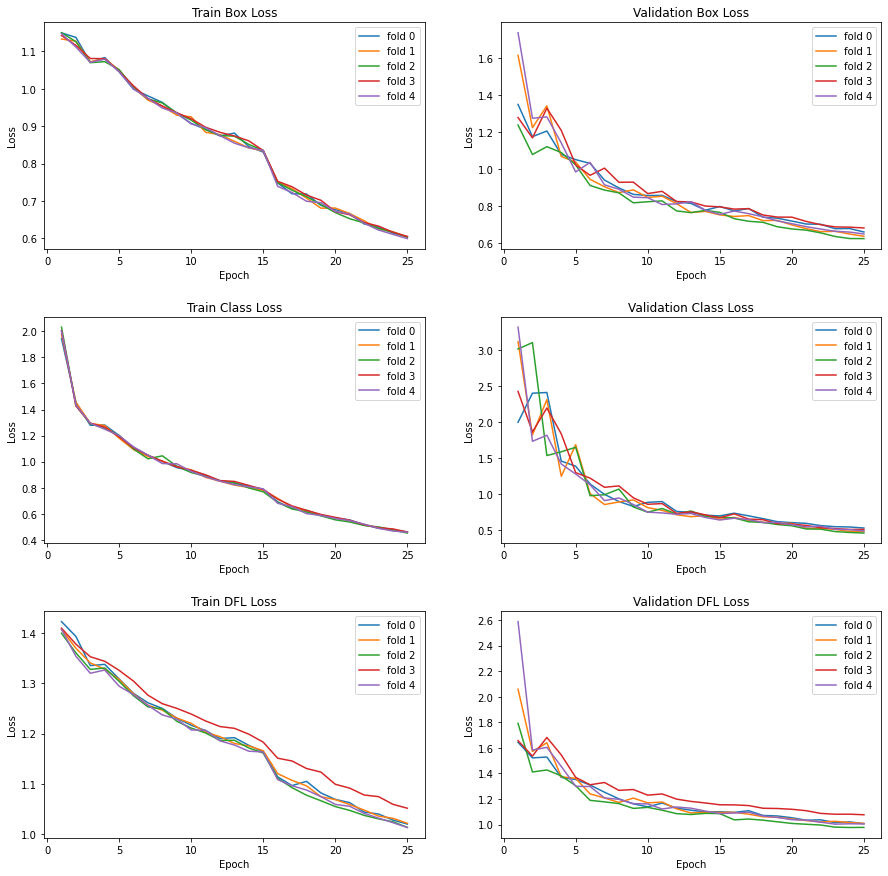

In [ ]:
df_all = pd.concat(all_results, ignore_index=True)

fig, axes = plt.subplots(3, 2, figsize=(15, 15))
fig.subplots_adjust(hspace=0.3)

metrics = [
    ('train/box_loss', 'Train Box Loss'),
    ('val/box_loss', 'Validation Box Loss'),
    ('train/cls_loss', 'Train Class Loss'),
    ('val/cls_loss', 'Validation Class Loss'),
    ('train/dfl_loss', 'Train DFL Loss'),
    ('val/dfl_loss', 'Validation DFL Loss')
]

for ax, (metric_col, metric_name) in zip(axes.flat, metrics):
    for f_id in range(k_folds):
        df_fold = df_all[df_all["fold"] == f_id]
        ax.plot(df_fold['epoch'], df_fold[metric_col], label=f'fold {f_id}')
    ax.set_title(metric_name)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.legend()

plt.show()

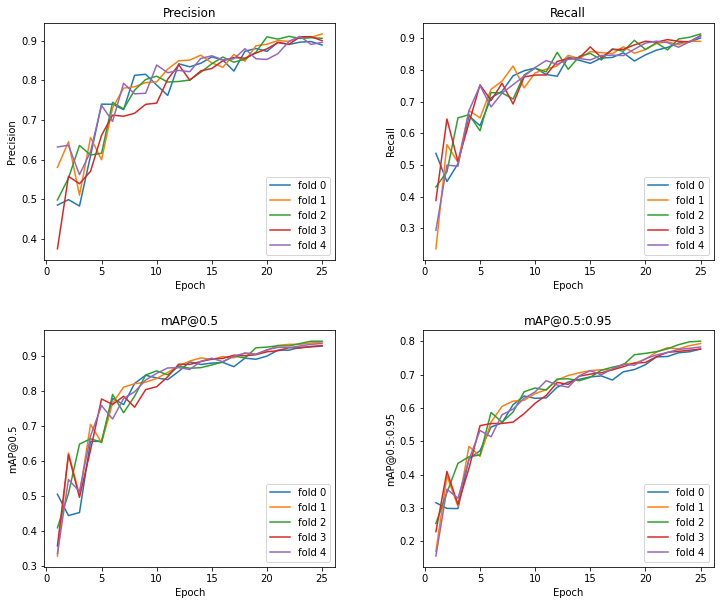

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

fig.subplots_adjust(hspace=0.3, wspace=0.3)

metrics = [
    ('metrics/precision(B)',   'Precision'),
    ('metrics/recall(B)',      'Recall'),
    ('metrics/mAP50(B)',       'mAP@0.5'),
    ('metrics/mAP50-95(B)',    'mAP@0.5:0.95')
]

for ax, (metric_col, metric_title) in zip(axes.flat, metrics):
    for fold_id in sorted(df_all['fold'].unique()):
        df_fold = df_all[df_all['fold'] == fold_id]
        ax.plot(df_fold['epoch'], df_fold[metric_col], label=f'fold {fold_id}')
    ax.set_title(metric_title)
    ax.set_ylabel(metric_title)
    ax.set_xlabel('Epoch')
    ax.legend()

plt.show()